# Running Wflow using the ewatercycle system

In [1]:
import ewatercycle
import ewatercycle.models
import ewatercycle.parameter_sets

/home/verhoes/miniconda39/envs/ewatercycle/lib/python3.9/site-packages/esmvalcore/experimental/_warnings.py:18: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498
/home/verhoes/miniconda39/envs/ewatercycle/lib/python3.9/site-packages/esmvalcore/experimental/config/_config_validators.py:254: ESMValToolDeprecationWarning: `write_plots` will be removed in 2.4.0.
/home/verhoes/miniconda39/envs/ewatercycle/lib/python3.9/site-packages/esmvalcore/experimental/config/_config_validators.py:255: ESMValToolDeprecationWarning: `write_netcdf` will be removed in 2.4.0.
/home/verhoes/miniconda39/envs/ewatercycle/lib/python3.9/site-packages/esmvalcore/experimental/config/_validated_config.py:80: MissingConfigParameter: `drs` is not defined (https://docs.esmvaltool.org/projects/ESMValCore/en/latest/quickstart/configure.html)


### 1. Copy an example case
To run WFlow, we need a complete parameterset. The package can download a example parameter set for you.

In [2]:
ewatercycle.CFG['container_engine'] = "docker"
ewatercycle.CFG['output_dir'] = "./"
ewatercycle.CFG['ewatercycle_config'] = './ewatercycle.yaml'
ewatercycle.CFG['parameterset_dir'] = './parameter-sets'

In [ ]:
ewatercycle.parameter_sets.download_example_parameter_sets()

In [4]:
ewatercycle.CFG.reload()

In [5]:
parameter_set = ewatercycle.parameter_sets.get_parameter_set('wflow_rhine_sbm_nc')
print(parameter_set)

Parameter set
-------------
name='wflow_rhine_sbm_nc'
directory=PosixPath('/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/parameter-sets/wflow_rhine_sbm_nc')
config=PosixPath('/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/parameter-sets/wflow_rhine_sbm_nc/wflow_sbm_NC.ini')
doi='N/A'
target_model='wflow'
supported_model_versions={'2020.1.1'}


### 2. Verify your configuration settings

If you are working on a curated environment like https://lab.ewatercycle.org/, the default configuration should cover 90% of all use cases. However, for the other 10% here is a brief explanation of the relevant configuration settings. 

The ewatercycle configuration file is typcially stored in `~/ewatercycle/ewatercycle.yaml` or `/etc/ewatercycle.yaml` and can be imported with `from ewatercycle import CFG`. Relevant settings for WFLow are:

```Yaml
container_engine: docker # or singularity
output_dir: './' # the directory where the model work_dir will be created
```

In order for this to work, you need to make sure that the actual docker or singularity images are available on the system. This can be done with:

- Docker: `docker pull ewatercycle/wflow-grpc4bmi:latest`
- Singularity: `singularity run docker://ewatercycle/wflow-grpc4bmi:latest` --> this will store a cached image.

### 3. Setting up the model

In [6]:
ewatercycle.models.Wflow.available_versions

('2020.1.1',)

In [7]:
# Load forcing data from an external source
import ewatercycle.forcing
forcing = ewatercycle.forcing.load_foreign(
    directory = "./parameter-sets/wflow_rhine_sbm_nc",
    target_model = 'wflow',
    start_time = '1991-01-01T00:00:00Z',
    end_time = '1991-12-31T00:00:00Z',
    forcing_info = dict(
        # Additional information about the external forcing data needed for the model configuration
        netcdfinput = "inmaps.nc",
        Precipitation = "/P",
        EvapoTranspiration = "/PET",
        Temperature = "/TEMP"
    )
)
print(forcing)

Forcing data for Wflow
----------------------
Directory: ./parameter-sets/wflow_rhine_sbm_nc
Start time: 1991-01-01T00:00:00Z
End time: 1991-12-31T00:00:00Z
Shapefile: None
Additional information for model config:
  - netcdfinput: inmaps.nc
  - Precipitation: /P
  - Temperature: /TEMP
  - EvapoTranspiration: /PET
  - Inflow: None


In [8]:
# Create the model instance and inspect the pre-configured parameters
model = ewatercycle.models.Wflow(version='2020.1.1', parameter_set=parameter_set, forcing=forcing)
model.parameters

[('start_time', '1991-01-01T00:00:00Z'), ('end_time', '1991-12-31T00:00:00Z')]

In [9]:
# Set up the model; this is where you can potentially overwrite some of the parameters
cfg_file, cfg_dir = model.setup(end_time = "1991-02-28T00:00:00Z")

Running docker://ewatercycle/wflow-grpc4bmi:2020.1.1 singularity container on port 52441


In [10]:
# See the run directory and model configuration file
print(cfg_file)
print(cfg_dir)

/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/wflow_20210629_135436/wflow_ewatercycle.ini
/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/wflow_20210629_135436


#### Update the config file

At this point, we have a preliminary configuration file. You can open it and modify. For the example below, you will have to add the variable "RiverRunoff" to the API section:

```
[API]
RiverRunoff = 2, m/s
```

After that, we can start up the model

### 4. Running the model

In [11]:
# Initialize the model
model.initialize(str(cfg_file))  # This conversion to string shouldn't be necessary

In [12]:
# Inspect the initial values for RiverRunoff
model.get_value("RiverRunoff")  # WFlow interally uses a fill-value for masked data of -999

array([-999., -999., -999., ..., -999., -999., -999.])

In [13]:
# You can also view get the data as xarray data-array
model.get_value_as_xarray("RiverRunoff")  # this automatically converts the -999 values to NaN

<xarray.DataArray 'RiverRunoff' (latitude: 169, longitude: 187)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 5.227 5.264 5.3 5.337 ... 11.97 12.01 12.05
  * latitude   (latitude) float64 45.89 45.93 45.97 46.0 ... 51.98 52.02 52.05
    time       object 1990-12-31 00:00:00
Attributes:
    units:     m/s

In [14]:
# Run the model until complete
while model.time < model.end_time:
    print(model.time)
    model.update()

662601600.0
662688000.0
662774400.0
662860800.0
662947200.0
663033600.0
663120000.0
663206400.0
663292800.0
663379200.0
663465600.0
663552000.0
663638400.0
663724800.0
663811200.0
663897600.0
663984000.0
664070400.0
664156800.0
664243200.0
664329600.0
664416000.0
664502400.0
664588800.0
664675200.0
664761600.0
664848000.0
664934400.0
665020800.0
665107200.0
665193600.0
665280000.0
665366400.0
665452800.0
665539200.0
665625600.0
665712000.0
665798400.0
665884800.0
665971200.0
666057600.0
666144000.0
666230400.0
666316800.0
666403200.0
666489600.0
666576000.0
666662400.0
666748800.0
666835200.0
666921600.0
667008000.0
667094400.0
667180800.0
667267200.0
667353600.0
667440000.0
667526400.0
667612800.0


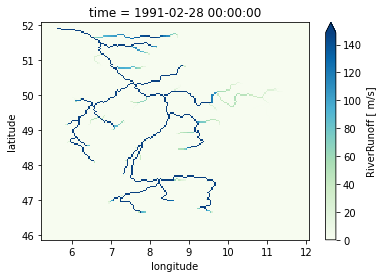

In [15]:
# Get the final output and create a simple plot
da = model.get_value_as_xarray("RiverRunoff")
da.plot(robust=True, cmap='GnBu')

In [16]:
# Cleaning up
model.finalize()
del(model)